
### Auteur : Houssam BIADI
### Source des données: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/download
### Version de python: 3.10.5
### IDE: Vs Code

In [12]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score

## Analyse exploratoire

In [3]:
# lecture des données
df = pd.read_csv('/Users/macbook/Downloads/heart_2020_cleaned.csv')
# séparation entre les variables quantitatives et qualitatives
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'], dtype='object')


Categorical Columns: Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')


In [3]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
pd.crosstab(df['GenHealth'],df['Race'],margins = True)

Race,American Indian/Alaskan Native,Asian,Black,Hispanic,Other,White,All
GenHealth,,,,,,,
Excellent,847,2222,3730,6226,2286,51531,66842
Fair,845,495,3674,4192,1363,24108,34677
Good,1806,2435,8101,8931,3358,68498,93129
Poor,348,118,975,903,517,8428,11289
Very good,1356,2798,6459,7194,3404,92647,113858
All,5202,8068,22939,27446,10928,245212,319795


In [5]:
# description des variables quantitatives 
df.describe().round(decimals = 2).drop(index = 'count')

,BMI,PhysicalHealth,MentalHealth,SleepTime
mean,28.33,3.37,3.90,7.10
std,6.36,7.95,7.96,1.44
min,12.02,0.00,0.00,1.00
25%,24.03,0.00,0.00,6.00
50%,27.34,0.00,0.00,7.00
75%,31.42,2.00,3.00,8.00
max,94.85,30.00,30.00,24.00


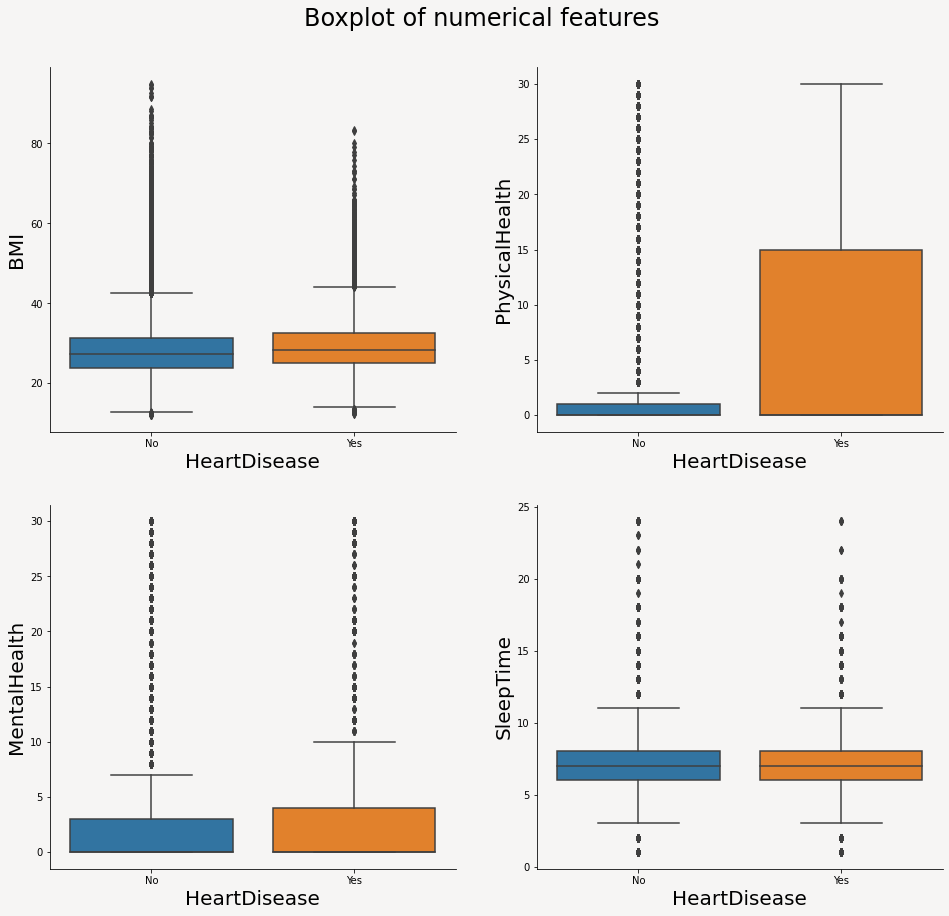

In [6]:
#Distribution des variables quantitatives dans chaque catégorie 
L = 4
ncol= 2
nrow= int(np.ceil(L/ncol))

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='#F6F5F4')   
fig.subplots_adjust(top=0.92)

i = 1
for col in numerical:
    plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
    
    ax = sns.boxplot(data=df, y=col, x="HeartDisease") 
    ax.set_xlabel('HeartDisease', fontsize=20)
    ax.set_ylabel(col, fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)
    if col == 'num_major_vessels':
        sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4])
        for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
    
    i = i +1
plt.suptitle('Boxplot of numerical features' ,fontsize = 24);

In [7]:
# test de student sur les deux populations (population malade vs population seine)
from scipy.stats import ttest_ind
results={}
for col in numerical:
    population_malade = df[df['HeartDisease']=='Yes'][col]
    population_seine = df[df['HeartDisease']=='No'][col]
    ttest,pval = ttest_ind(population_malade,population_seine)
    r = 'Reject H0' if pval<0.05 else 'Dont reject H0' 
    results[col] = [ttest,pval,r]
results = pd.DataFrame.from_dict(results).T
results.rename(columns={0:'ttest',1:'pval',2:'test_results'})




,ttest,pval,test_results
BMI,29.334217,0.0,Reject H0
PhysicalHealth,97.981551,0.0,Reject H0
MentalHealth,16.174731,0.0,Reject H0
SleepTime,4.708902,0.000002,Reject H0


### La matrice de corrélation (Les coéfficients de Pearson)

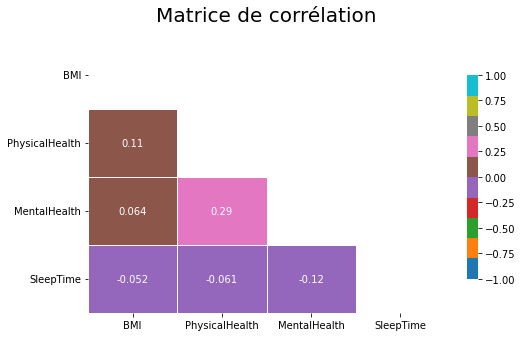

In [9]:
corr = df[numerical].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Matrice de corrélation", fontsize=20, y= 1.05);

## Etude des variables qualitatives

In [10]:
# frequence des modalités 

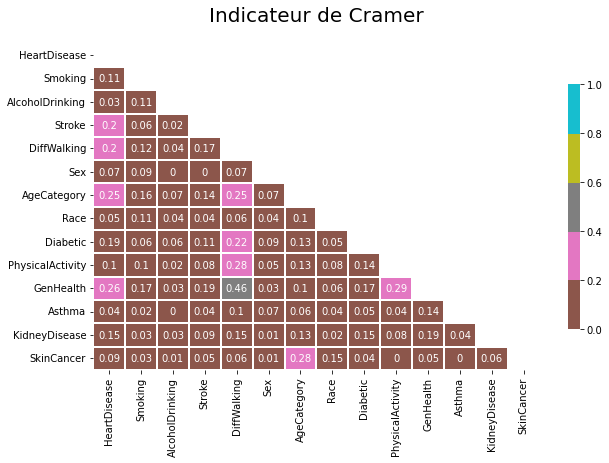

In [11]:
# distance de khi2 et indicateur de Cramer
from scipy import stats
def cramers_v(x, y): 
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

rows = []
for x in categorical:
    col = []
    for y in categorical :
        cramers =cramers_v(df[x], df[y]) 
        col.append(round(cramers,2))
    rows.append(col)
    
cramers_results = np.array(rows)
cramer_df = pd.DataFrame(cramers_results, columns = categorical, index = categorical)


mask = np.triu(np.ones_like(cramer_df, dtype=bool))
corr = cramer_df.mask(mask)
f, ax = plt.subplots(figsize=(10, 6), facecolor=None)
cmap = sns.color_palette( as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Indicateur de Cramer", fontsize=20, y= 1.05);

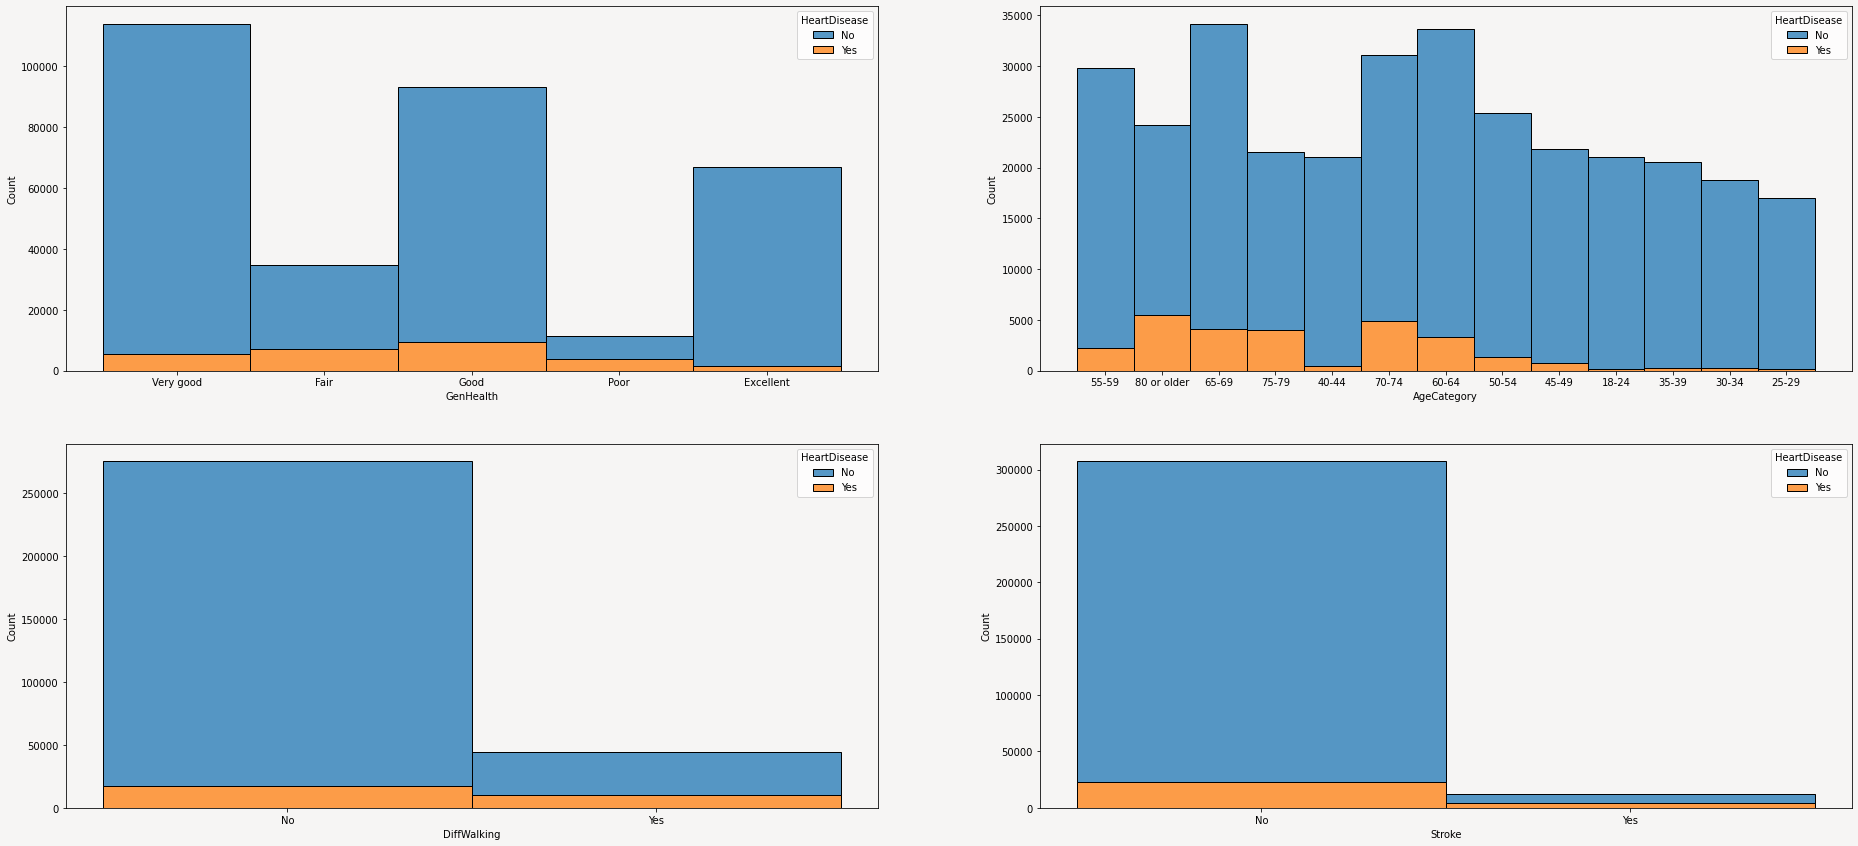

In [12]:
L = 4
ncol= 2
nrow= int(np.ceil(L/ncol))

fig, ax = plt.subplots(nrow, ncol, figsize=(32, 14),facecolor='#F6F5F4')   
fig.subplots_adjust(top=0.92)
i = 1
for column in ['GenHealth','AgeCategory','DiffWalking','Stroke']:
              plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
              sns.histplot(binwidth=0.5, x=column, hue="HeartDisease", data=df, stat="count", multiple="stack")
              i = i+1

## Modélisation

In [13]:
# Encodage des variables qualitatives
df_encoded = df.copy()
# encodage binaire
dict_binaire = {'Yes': 1,'No': 0}
variables_binaires = ['HeartDisease','Smoking','AlcoholDrinking','Stroke','DiffWalking','PhysicalActivity','Asthma','KidneyDisease','SkinCancer']
for column in variables_binaires:
    df_encoded[column] = df_encoded[column].map(dict_binaire)
# variable sex
dict_sex = {'Female': 1,'Male': 0}
df_encoded['Sex'] = df_encoded['Sex'].map(dict_sex)
# variable ordinale: GenHealth
dict_health = {'Poor':0,'Fair':1,'Good':2,'Very good':3,'Excellent':4}
df_encoded['GenHealth'] = df_encoded['GenHealth'].map(dict_health)
# variable ordinale: AgeCatagory
dict_age = {'18-24':1,'25-29':2,'30-34':3,'35-39':4,'40-44':5,'45-49':6,'50-54':7,'55-59':8,'60-64':9,'65-69':10,'70-74':11,'75-79':12,'80 or older':13}
df_encoded['AgeCategory'] = df_encoded['AgeCategory'].map(dict_age)
# One hot encoding des variables Race et Diabetic
df_encoded = pd.get_dummies(df_encoded, drop_first=True)
df_encoded.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,KidneyDisease,SkinCancer,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,0,16.60,1,0,0,3.0,30.0,0,1,8,...,0,1,0,0,0,0,1,0,1,0
1,0,20.34,0,0,1,0.0,0.0,0,1,13,...,0,0,0,0,0,0,1,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,0,10,...,0,0,0,0,0,0,1,0,1,0
3,0,24.21,0,0,0,0.0,0.0,0,1,12,...,0,1,0,0,0,0,1,0,0,0
4,0,23.71,0,0,0,28.0,0.0,1,1,5,...,0,0,0,0,0,0,1,0,0,0


In [14]:
X = df_encoded.drop(["HeartDisease"], axis=1) # Une matrice qui contient toutes les variables explicatives
y = df_encoded["HeartDisease"] # La variable cible

In [15]:
# divsion de nos données en troix bases, l'entrainement,l'évaluation et le test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state = 42)
X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state = 101)




### Les arbres de décision

In [16]:
def train_val(y_train, y_train_pred,y_train_proba, y_test, y_pred,y_test_proba):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred),
                            "AUC": roc_auc_score(y_train,y_train_proba)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred),
                           "AUC": roc_auc_score(y_test,y_test_proba)},}
    
    return pd.DataFrame(scores)

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
              "max_features":[3, 5, 7],
              "max_depth": [4, 5, 6, 7],
              "min_samples_split": [2, 3, 5,10]}

model = DecisionTreeClassifier(class_weight = "balanced", random_state=42)
# Entrainement du modèle
DT_grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            cv = 5,
                            n_jobs = -1, verbose = 0).fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,train_set,test_set
Accuracy,0.686226,0.682750
Precision,0.191824,0.188234
Recall,0.829640,0.817136
f1,0.311601,0.305982
AUC,0.822803,0.813502


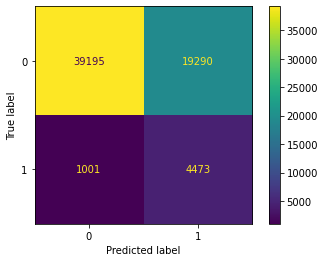

In [22]:
# calcul de la prédiction et de la probabilité de l'appartenance à la classe 1
y_pred = DT_grid_model.predict(X_test)
y_test_proba = DT_grid_model.predict_proba(X_test)[:,1]
y_train_pred = DT_grid_model.predict(X_train)
y_train_proba = DT_grid_model.predict_proba(X_train)[:,1]
# calcul des scores et de la matrice de confusion
plot_confusion_matrix(DT_grid_model, X_test, y_test)

train_val(y_train, y_train_pred,y_train_proba, y_test, y_pred,y_test_proba)

In [23]:
DT_grid_model.best_params_

{'max_depth': 7, 'max_features': 7, 'min_samples_split': 2}

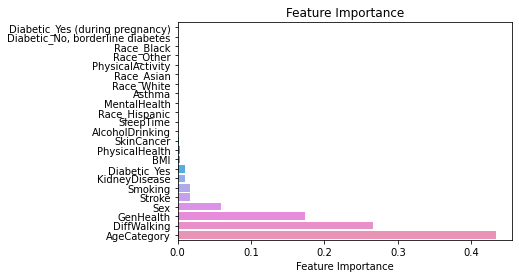

In [58]:
DT_feature_imp = pd.DataFrame(index=X.columns, data = DT_grid_model.best_estimator_.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance")
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [69]:
'''from sklearn.tree import plot_tree,export_graphviz
import graphviz
dot_data = export_graphviz(DT_grid_model.best_estimator_, out_file=None, 
                    feature_names=X.columns,  
                    class_names='HeartDesease',  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 
'''

"from sklearn.tree import plot_tree,export_graphviz\nimport graphviz\ndot_data = export_graphviz(DT_grid_model.best_estimator_, out_file=None, \n                    feature_names=X.columns,  \n                    class_names='HeartDesease',  \n                    filled=True, rounded=True,  \n                    special_characters=True)  \ngraph = graphviz.Source(dot_data)  \ngraph \n"

### Les forêts aléatoires

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#Modelling Random Forest (RF) with Best Parameters 
param_grid = {'n_estimators':[50, 100],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}
RF_grid_model = RandomForestClassifier(random_state=42)

RF_grid_model = GridSearchCV(estimator=RF_grid_model, 
                             param_grid=param_grid, 
                             scoring = "roc_auc", 
                             n_jobs = -1, verbose = 0).fit(X_train, y_train)

KeyboardInterrupt: 

In [72]:
RF_grid_model.best_params_

{'max_depth': 9,
 'max_features': 4,
 'min_samples_split': 5,
 'n_estimators': 100}

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
RF_model = RandomForestClassifier(n_estimators = 100,max_features = 4, random_state=42,max_depth = 9,min_samples_split = 5, class_weight={1:9,0:1})
RF_model.fit(X_train,y_train)


RandomForestClassifier(class_weight={0: 1, 1: 9}, max_depth=9, max_features=4,
                       min_samples_split=5, random_state=42)

In [20]:
#import pickle
#pickle.dump(RF_model,open('model_V3.pkl','wb'))
import joblib

# ... (Your model training code)

# Export your model
model_filename = 'model.joblib'
joblib.dump(RF_model, model_filename)

['model.joblib']

In [18]:
X_test.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,...,KidneyDisease,SkinCancer,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
243668,24.21,0,0,0,0.0,0.0,0,1,8,1,...,0,0,0,1,0,0,0,0,0,0
213033,31.32,0,0,0,5.0,0.0,0,0,8,0,...,1,0,0,0,0,0,1,0,0,0
229530,29.12,0,0,0,15.0,22.0,1,1,8,0,...,0,0,0,0,0,0,1,0,1,0
163587,27.76,1,0,0,0.0,0.0,0,1,12,1,...,0,1,0,0,0,0,1,0,0,0
253178,19.91,0,0,0,0.0,0.0,0,1,9,1,...,0,0,0,0,0,0,1,0,0,0


,train_set,test_set
Accuracy,0.773772,0.768617
Precision,0.240808,0.232025
Recall,0.763212,0.737486
f1,0.366103,0.352993
AUC,0.850511,0.834647


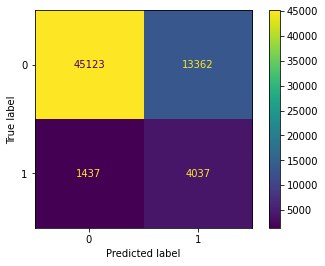

In [76]:
# calcul de la prédiction et de la probabilité de l'appartenance à la classe 1
y_pred = RF_model.predict(X_test)
y_test_proba = RF_model.predict_proba(X_test)[:,1]
y_train_pred = RF_model.predict(X_train)
y_train_proba = RF_model.predict_proba(X_train)[:,1]
# calcul des scores et de la matrice de confusion
plot_confusion_matrix(RF_model, X_test, y_test)

train_val(y_train, y_train_pred,y_train_proba, y_test, y_pred,y_test_proba)

In [90]:
# Création d'une base de données balancée
L_train = X_train.index.tolist()
df_train = df_encoded[df_encoded.index.isin(L_train)]
# Class count

# Divide by class
df_class_0 = df_train[df_train['HeartDisease'] == 0]
df_class_1 = df_train[df_train['HeartDisease'] == 1]
count_class_1 = len(df_class_1)
df_class_0_under = df_class_0.sample(count_class_1)
df_train_balanced = pd.concat([df_class_0_under, df_class_1], axis=0)



In [94]:
X_train_balanced = df_train_balanced.drop(["HeartDisease"], axis=1) 
y_train_balanced = df_train_balanced["HeartDisease"]
# entrainement
RF_model = RandomForestClassifier(n_estimators = 100,max_features = 4, random_state=42,max_depth = 9,min_samples_split = 5, class_weight='balanced')
RF_model.fit(X_train_balanced,y_train_balanced)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=4,
                       min_samples_split=5, random_state=42)

,train_set,test_set
Accuracy,0.724918,0.720227
Precision,0.213870,0.207352
Recall,0.827326,0.803800
f1,0.339878,0.329662
AUC,0.848307,0.835303


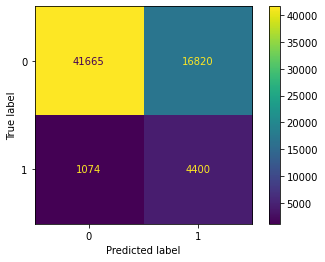

In [95]:
# calcul de la prédiction et de la probabilité de l'appartenance à la classe 1
y_pred = RF_model.predict(X_test)
y_test_proba = RF_model.predict_proba(X_test)[:,1]
y_train_pred = RF_model.predict(X_train)
y_train_proba = RF_model.predict_proba(X_train)[:,1]
# calcul des scores et de la matrice de confusion
plot_confusion_matrix(RF_model, X_test, y_test)

train_val(y_train, y_train_pred,y_train_proba, y_test, y_pred,y_test_proba)

### La régression logistique

In [98]:
from sklearn.linear_model import LogisticRegression
penalty = "l2"
C = 0.1

param_grid = {"penalty" : penalty,
             "l1_ratio" : l1_ratio,
             "C" : C}
LR_model = LogisticRegression(penalty = penalty, C = C, solver='saga', max_iter=5000, class_weight = "balanced")

LR_model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=5000, solver='saga')

,train_set,test_set
Accuracy,0.747265,0.746572
Precision,0.223248,0.221270
Recall,0.787567,0.778407
f1,0.347883,0.344588
AUC,0.841429,0.836984


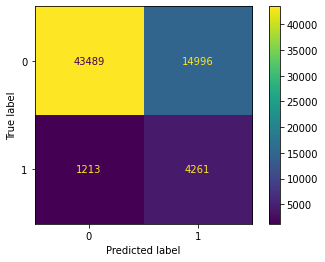

In [99]:
# calcul de la prédiction et de la probabilité de l'appartenance à la classe 1
y_pred = LR_model.predict(X_test)
y_test_proba = LR_model.predict_proba(X_test)[:,1]
y_train_pred = LR_model.predict(X_train)
y_train_proba = LR_model.predict_proba(X_train)[:,1]
# calcul des scores et de la matrice de confusion
plot_confusion_matrix(LR_model, X_test, y_test)

train_val(y_train, y_train_pred,y_train_proba, y_test, y_pred,y_test_proba)

,train_set,eval_test
Accuracy,0.724918,0.722260
Precision,0.213870,0.211268
Recall,0.827326,0.821187
f1,0.339878,0.336074
AUC,0.848307,0.841557


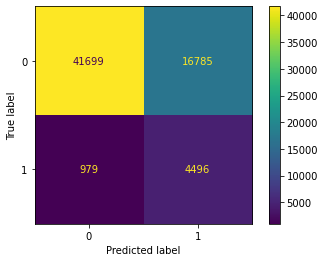

In [102]:
# pérformance sir l'échantillon d'évaluation
y_pred = RF_model.predict(X_eval)
y_eval_proba = RF_model.predict_proba(X_eval)[:,1]
y_train_pred = RF_model.predict(X_train)
y_train_proba = RF_model.predict_proba(X_train)[:,1]
# calcul des scores et de la matrice de confusion
plot_confusion_matrix(RF_model, X_eval, y_eval)

eval = train_val(y_train, y_train_pred,y_train_proba, y_eval, y_pred,y_eval_proba)
eval = eval.rename(columns={'test_set':'eval_test'})
eval